In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM, LUNA
from src.utils import generate_data

In [2]:
from autograd import numpy as np
import matplotlib.pyplot as plt

In [3]:
# def generate_data_periodic(number_of_points=10, noise_variance=9):
#     """Function for generating toy regression data"""
#     #training x
#     x_train = np.hstack((np.linspace(-4, -1, number_of_points), np.linspace(1, 4, number_of_points)))
#     #function relating x and y
#     f = lambda x: x**3 + 20 * np.sin(7 * x)
#     #y is equal to f(x) plus gaussian noise
#     y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
#     # x_test = np.array(list(set(list(np.hstack((np.linspace(-5, , 100), x_train))))))
#     x_test = np.array(list(set(list((np.linspace(-6, 6, 100))))))
#     x_test = np.sort(x_test)
#     return x_train, y_train, x_test

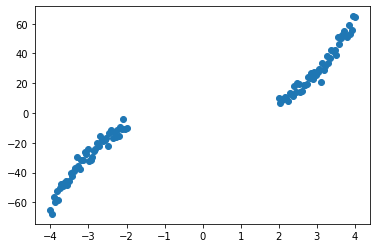

In [4]:
x, y, x_test = generate_data(number_of_points=50, noise_variance=9)

plt.scatter(x, y)

plt.show()

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.exp(-x**2)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = LUNA(architecture, random=random)
print('Number of parameters =',nn.D)

Number of parameters = 5200


## Inspect distribution of coSim^2 before training

Text(0, 0.5, 'Count')

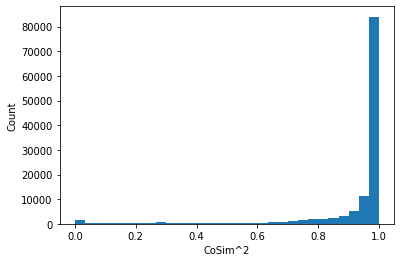

In [6]:
grad_FD = nn._finite_diff_grad(nn.weights, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count')

## Inspect auxiliary functions before training

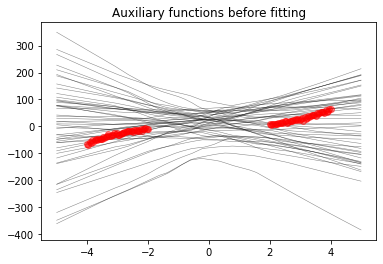

In [7]:
y_pred = nn.forward(nn.weights, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions before fitting')
plt.show()

## Training LUNA

In [8]:
### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':5000,
    'random_restarts':1,
    'reg_param':1.,
    'lambda_in':1.,
}

# fit LUNA
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 loss 11678.068970116226; gradient mag: 5444.074725713978
Iteration 100 loss 918.7573056830603; gradient mag: 959.6021894962618
Iteration 200 loss 861.26893599186; gradient mag: 405.16466251132755
Iteration 300 loss 843.5805693623972; gradient mag: 222.8855899020874
Iteration 400 loss 828.282389425392; gradient mag: 632.3022120662829
Iteration 500 loss 820.586468991712; gradient mag: 521.4202302397827
Iteration 600 loss 821.3636515584174; gradient mag: 851.8225503298537
Iteration 700 loss 822.723939455973; gradient mag: 1038.0481409907848
Iteration 800 loss 816.8746248473421; gradient mag: 267.2142484167637
Iteration 900 loss 815.9922136718375; gradient mag: 435.49136542548615
Iteration 1000 loss 815.8299331312824; gradient mag: 514.6013570071602
Iteration 1100 loss 816.5646858224483; gradient mag: 668.6973734174404
Iteration 1200 loss 813.3782894964756; gradient mag: 239.42997504099304
Iteration 1300 loss 812.5038507162815; gradient mag: 81.82538821621067
Iteration 1400 los

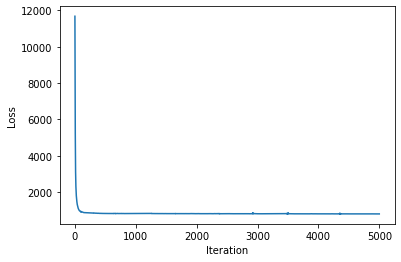

In [9]:
plt.plot(nn.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Inspect distribution of coSim^2 after training

Text(0, 0.5, 'Count')

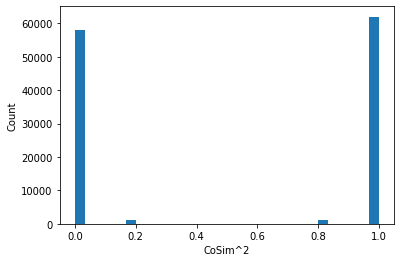

In [10]:
grad_FD = nn._finite_diff_grad(nn.weights, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count')

## Inspect auxiliary functions after training

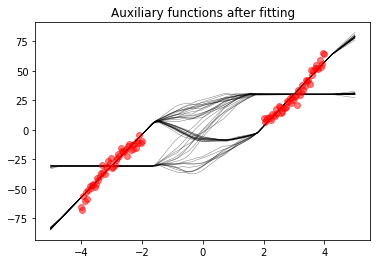

In [11]:
y_pred = nn.forward(nn.weights, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions after fitting')
plt.show()

## Plot prior predictive

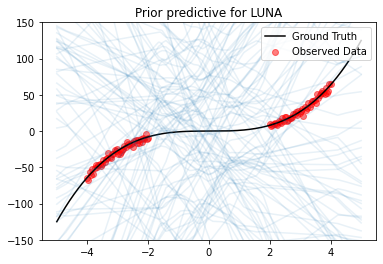

In [12]:
prior_mean = 0
prior_var = 9
noise_var = 9
y_prior = nn.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

## Plot posterior predictive

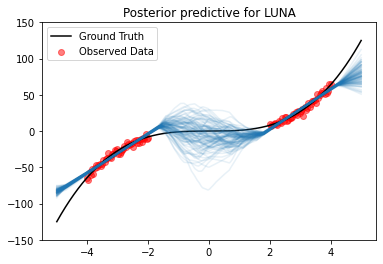

In [13]:
y_posterior = nn.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

In [14]:
# Calulating percentiles
pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

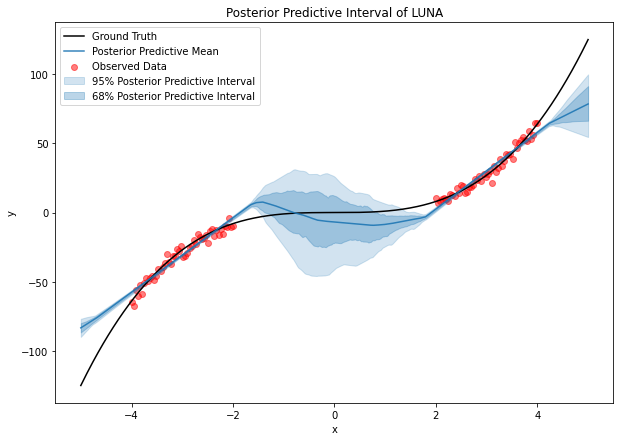

In [15]:
# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

## Compare to NLM

In [16]:
# instantiate a NLM with same architecture and training parameters
nlm = NLM(architecture, random = random)
nlm.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 loss 5947.779298098167; gradient mag: 17111.567759121768
Iteration 100 loss 70.20585302162766; gradient mag: 69.68489369405096
Iteration 200 loss 52.13215352488152; gradient mag: 9.149649845818768
Iteration 300 loss 49.76266901615426; gradient mag: 4.974730948685335
Iteration 400 loss 48.657105581554845; gradient mag: 32.202330509202845
Iteration 500 loss 47.8372822095355; gradient mag: 27.878822597551395
Iteration 600 loss 47.20557864887256; gradient mag: 47.86991090377436
Iteration 700 loss 46.535416535375134; gradient mag: 14.766694588756375
Iteration 800 loss 46.00047693241616; gradient mag: 31.80016215832031
Iteration 900 loss 45.4468299758933; gradient mag: 21.591445943922466
Iteration 1000 loss 44.94643430320468; gradient mag: 34.32736754000083
Iteration 1100 loss 44.51582833478956; gradient mag: 64.47214430375152
Iteration 1200 loss 43.968049466970896; gradient mag: 27.620914369968418
Iteration 1300 loss 43.49650448979245; gradient mag: 42.00849855503791
Iteration 1

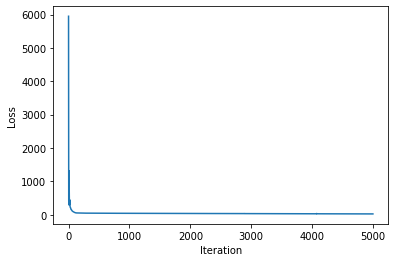

In [17]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

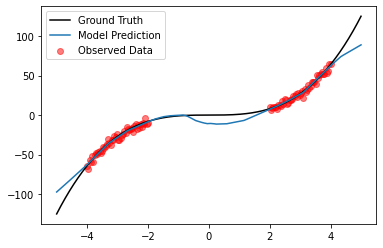

In [18]:
y_pred = nlm.forward(nlm.weights, x_test)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_pred[0,0,:], color='tab:blue', label="Model Prediction")
plt.legend()
plt.show()

## Plot prior predictive

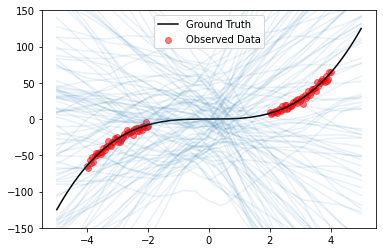

In [19]:
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.legend()
plt.show()

## Plot posterior predictive

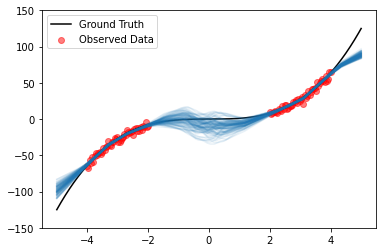

In [20]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.legend()
plt.show()

In [21]:
# Calulating percentiles
pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

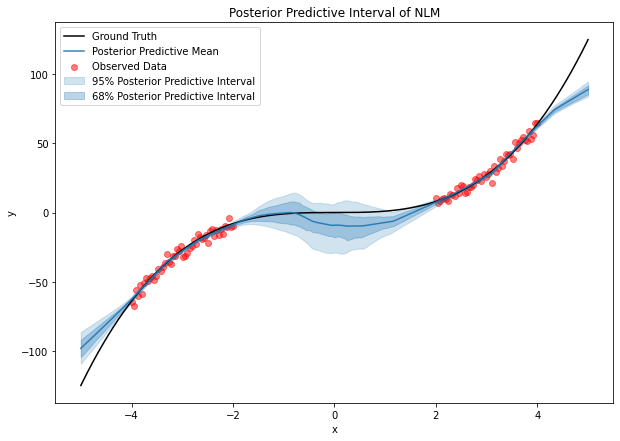

In [22]:
# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], x_test[0,:]**3, color='black', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()